In [150]:
!pip install librosa tensorflow-io scikit-learn resampy

In [151]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow_io as tfio
import librosa
import librosa.display
import pandas as pd
import numpy as np
import resampy
import os

%matplotlib inline

In [152]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_data(test_size=0.2, chunk_duration=1):
    x, y = [], []
    for file in os.listdir('/content/drive/MyDrive/samples'):
        audio, sample_rate = librosa.load('/content/drive/MyDrive/samples/' + file, res_type='kaiser_fast')
        num_chunks = int(np.ceil(len(audio) / (sample_rate * chunk_duration)))

        for i in range(num_chunks):
            start = int(i * sample_rate * chunk_duration)
            end = min(len(audio), int((i + 1) * sample_rate * chunk_duration))
            chunk_audio = audio[start:end]
            feature = extract_features_from_audio(chunk_audio, sample_rate)
            x.append(feature)
            class_label = file.split('(')[0]
            y.append(class_label)

    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=42)

In [153]:
def extract_features_from_audio(audio, sample_rate, mfcc=True, chroma=True, mel=True):
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_fft=1024).T, axis=0)  # Adjust n_fft
        result = np.hstack((result, mfccs))
    if chroma:
        stft = np.abs(librosa.stft(audio, n_fft=1024))  # Adjust n_fft
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=1024).T, axis=0)  # Adjust n_fft
        result = np.hstack((result, mel))
    return result

In [154]:
from tensorflow.keras import layers, models

from tensorflow.keras.layers import Dropout

def create_model_with_dropout(input_shape, num_classes, dropout_rate=0.5):
    model = models.Sequential()

    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))


    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))

    model.add(Dropout(dropout_rate))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [155]:
X_train, X_test, y_train, y_test = load_data()

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=70
  warnings.warn(


In [156]:
input_shape = (X_train.shape[1], 1)
num_classes=4

model_with_dropout = create_model_with_dropout(input_shape=input_shape, num_classes=num_classes)

model_with_dropout.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_with_dropout.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_66 (Conv1D)          (None, 178, 32)           128       
                                                                 
 max_pooling1d_66 (MaxPooli  (None, 89, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_67 (Conv1D)          (None, 87, 64)            6208      
                                                                 
 max_pooling1d_67 (MaxPooli  (None, 43, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_68 (Conv1D)          (None, 41, 128)           24704     
                                                                 
 max_pooling1d_68 (MaxPooli  (None, 20, 128)         

In [157]:
history = model_with_dropout.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
16/16 [==============================] - 3s 57ms/step - loss: 1.4945 - accuracy: 0.3840 - val_loss: 1.0546 - val_accuracy: 0.5635
Epoch 2/50
16/16 [==============================] - 1s 54ms/step - loss: 1.0063 - accuracy: 0.5780 - val_loss: 0.8471 - val_accuracy: 0.6587
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.8105 - accuracy: 0.6720 - val_loss: 0.7025 - val_accuracy: 0.6905
Epoch 4/50
16/16 [==============================] - 1s 43ms/step - loss: 0.7073 - accuracy: 0.7280 - val_loss: 0.6166 - val_accuracy: 0.7302
Epoch 5/50
16/16 [==============================] - 1s 41ms/step - loss: 0.6575 - accuracy: 0.7300 - val_loss: 0.5966 - val_accuracy: 0.7302
Epoch 6/50
16/16 [==============================] - 1s 78ms/step - loss: 0.5545 - accuracy: 0.7740 - val_loss: 0.4744 - val_accuracy: 0.8175
Epoch 7/50
16/16 [==============================] - 1s 68ms/step - loss: 0.5145 - accuracy: 0.8020 - val_loss: 0.5654 - val_accuracy: 0.8333
Epoch 8/50
16

In [158]:
test_loss, test_acc = model_with_dropout.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

4/4 [==============================] - 0s 10ms/step - loss: 0.3156 - accuracy: 0.8889
Test accuracy: 0.8888888955116272


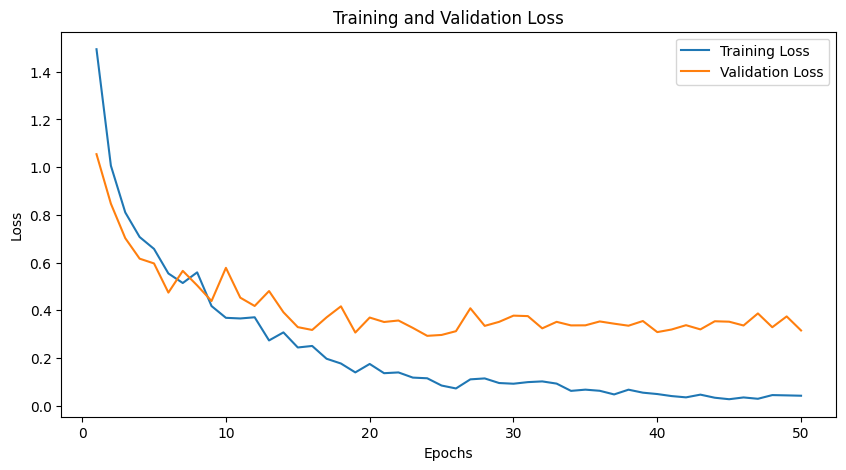

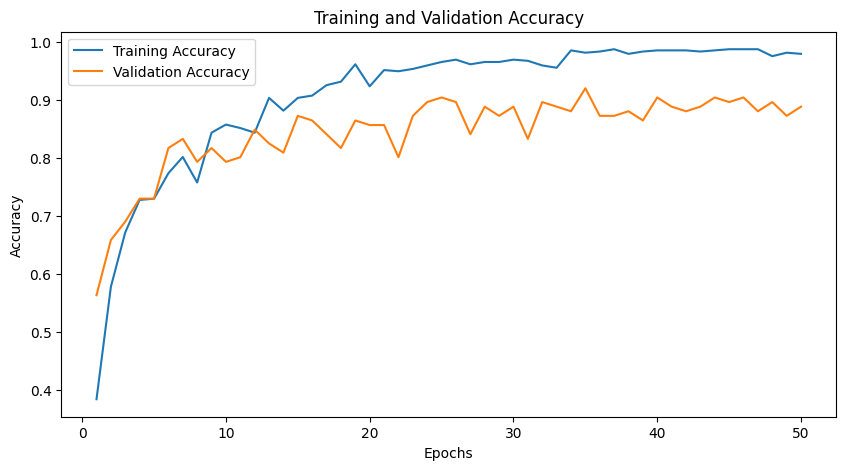

In [159]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()